In [1]:
## Imports
import os
import sys
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [6]:
dataset_path = "dataset/"
train_path = os.path.join(dataset_path, "train/")

In [9]:
## Data Generator
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=256, **kwargs):
        super().__init__(**kwargs)  # Call the parent class constructor explicitly
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "/Users/gaurangjadhav/Downloads/Deep-Residual-Unet-master 2/dataset/train/images", id_name) + ".png"
        mask_path = os.path.join(self.path, "/Users/gaurangjadhav/Downloads/Deep-Residual-Unet-master 2/dataset/train/masks", id_name) + ".png"
        
        ## Reading Image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        ##Reading Mask
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
        
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.ids))
        files_batch = self.ids[start_idx:end_idx]
    # Logic to load and return data for the batch

        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [64]:
train_csv = pd.read_csv(os.path.join(dataset_path, "train.csv"))
train_ids = train_csv["id"].values

# Shuffle the dataset
np.random.shuffle(train_ids)

total_samples = len(train_csv)
train_samples = int(total_samples * 0.8)
val_samples = int(total_samples * 0.1)
test_samples = int(total_samples * 0.1)

val_data_size = test_data_size = val_samples
train_ids = train_csv["id"].values[:train_samples]
test_ids = train_csv["id"].values[train_samples:train_samples + test_samples]
val_ids = train_csv["id"].values[train_samples + test_samples:]

print("Number of samples for training:", len(train_ids))
print("Number of samples for validation:", len(val_ids))
print("Number of samples for testing:", len(test_ids))

image_size = 128
batch_size = 16

Number of samples for training: 3200
Number of samples for validation: 400
Number of samples for testing: 400


In [65]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
val_gen = DataGen(val_ids, train_path, image_size=image_size, batch_size=batch_size)
test_gen = DataGen(test_ids, train_path, image_size=image_size, batch_size=batch_size)

x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

x, y = val_gen.__getitem__(0)
print(x.shape, y.shape)

x, y = test_gen.__getitem__(0)
print(x.shape, y.shape)

(16, 128, 128, 3) (16, 128, 128, 1)
(16, 128, 128, 3) (16, 128, 128, 1)
(16, 128, 128, 3) (16, 128, 128, 1)


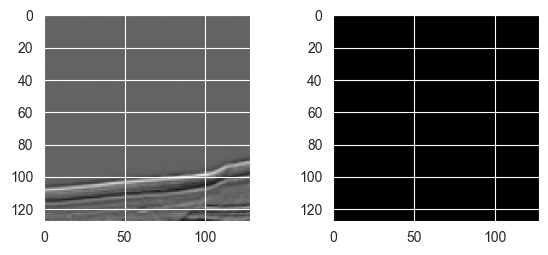

In [68]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r]*255, (image_size, image_size)), cmap="gray")

In [69]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [70]:
## ResUNet
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [71]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [72]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ... rest of your code ...

checkpoint_filepath = 'best_weights.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                            monitor='val_loss',
                            save_best_only=True,
                            mode='min')


In [73]:
from tensorflow.keras.optimizers import legacy  # Import legacy optimizers

model = ResUNet()
adam = legacy.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])
model.summary()



model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_210 (Conv2D)         (None, 128, 128, 16)         448       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_196 (B  (None, 128, 128, 16)         64        ['conv2d_210[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_133 (Activation  (None, 128, 128, 16)         0         ['batch_normalization_19

In [74]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

epochs = 25

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_weights_only=True, save_best_only=True)

history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs, callbacks=[checkpoint_callback])

Epoch 1/25
200/200 [==============================] - 357s 2s/step - loss: 0.3680 - dice_coef: 0.6320 - val_loss: 0.6065 - val_dice_coef: 0.3935
Epoch 2/25
200/200 [==============================] - 597s 3s/step - loss: 0.2926 - dice_coef: 0.7074 - val_loss: 0.4260 - val_dice_coef: 0.5740
Epoch 3/25
200/200 [==============================] - 755s 4s/step - loss: 0.2885 - dice_coef: 0.7115 - val_loss: 1.0000 - val_dice_coef: 2.4393e-05
Epoch 4/25
200/200 [==============================] - 696s 3s/step - loss: 0.3023 - dice_coef: 0.6977 - val_loss: 0.6070 - val_dice_coef: 0.3930
Epoch 5/25
200/200 [==============================] - 663s 3s/step - loss: 0.2489 - dice_coef: 0.7511 - val_loss: 0.3093 - val_dice_coef: 0.6907
Epoch 6/25
200/200 [==============================] - 671s 3s/step - loss: 0.2440 - dice_coef: 0.7560 - val_loss: 0.5823 - val_dice_coef: 0.4177
Epoch 7/25
200/200 [==============================] - 704s 4s/step - loss: 0.2304 - dice_coef: 0.7696 - val_loss: 0.2487 - val

In [76]:

model.save_weights("ResUnet.h5")


      Ground Truth            Predicted Value
1/1 [==============================] - 1s 515ms/step


/var/folders/f1/67sjbbms1t383h01w7p2zsnw0000gn/T/ipykernel_44657/2715254381.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


1/1 [==============================] - 0s 468ms/step


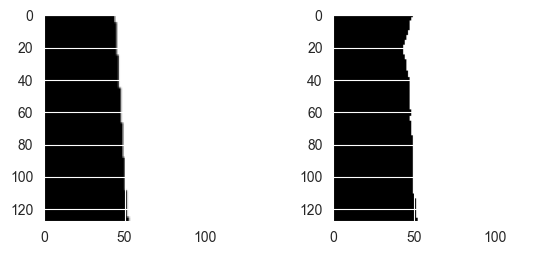

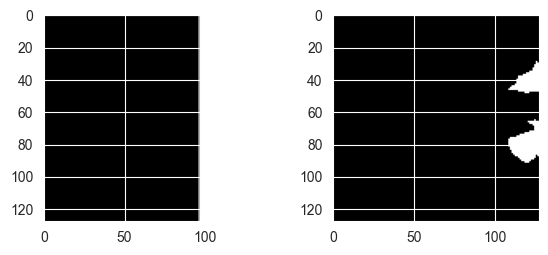

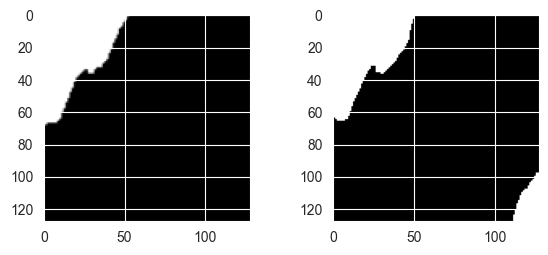

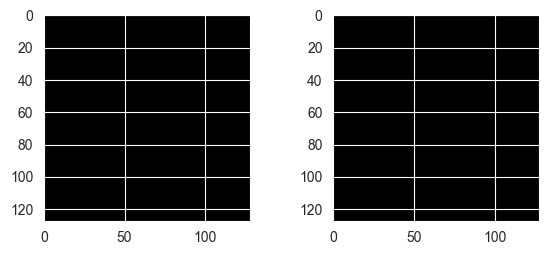

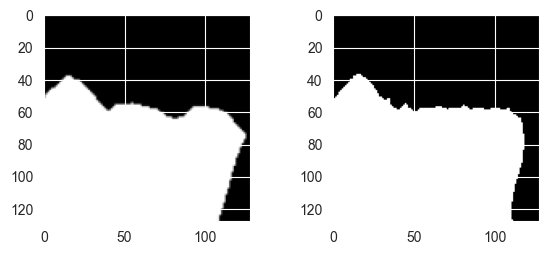

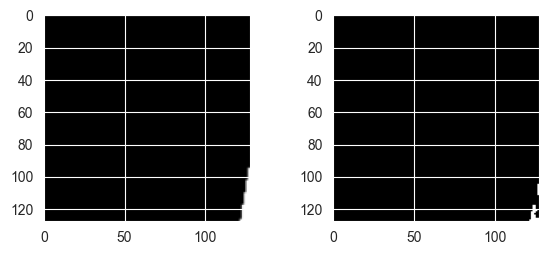

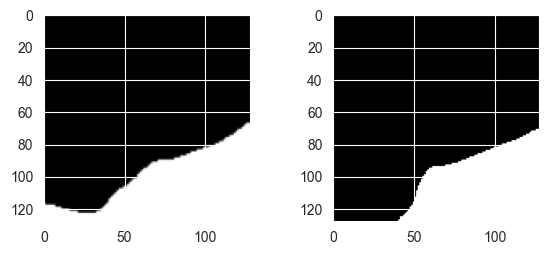

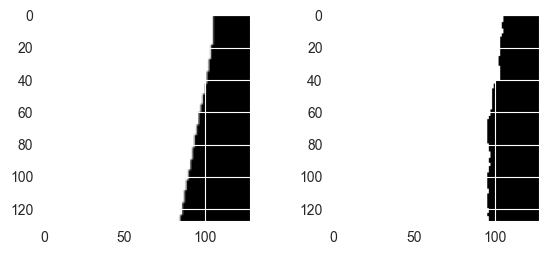

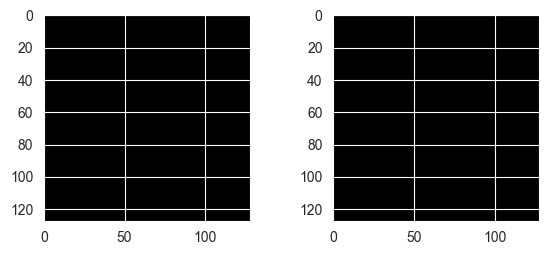

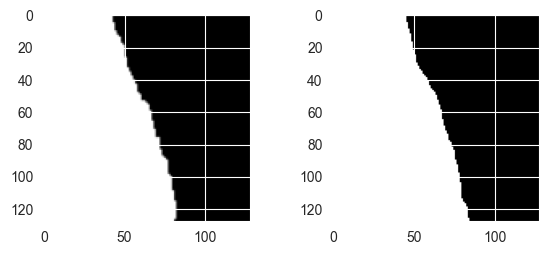

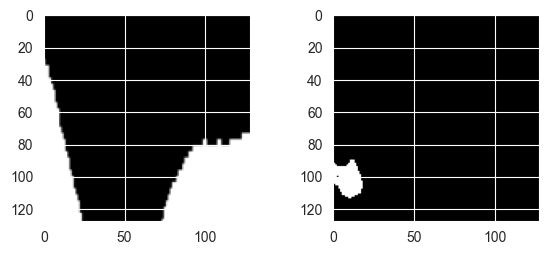

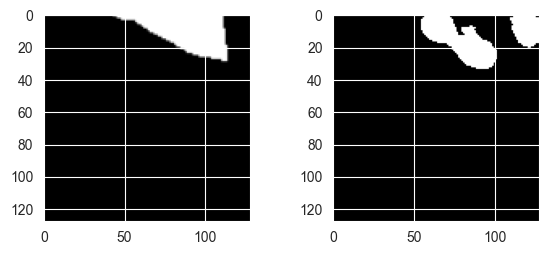

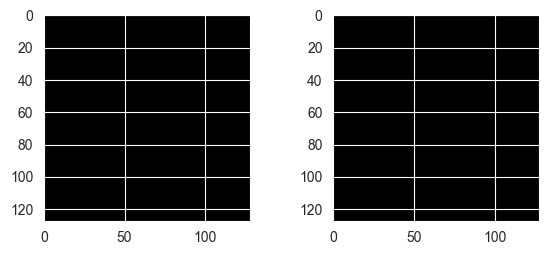

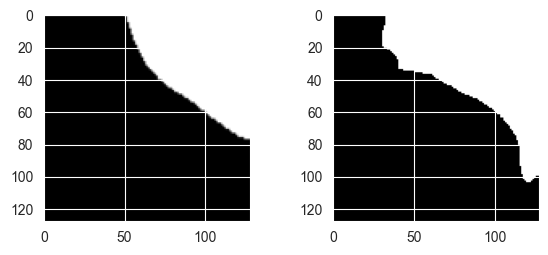

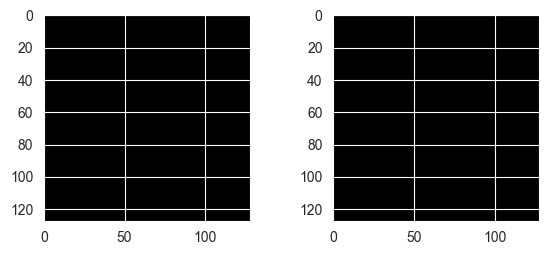

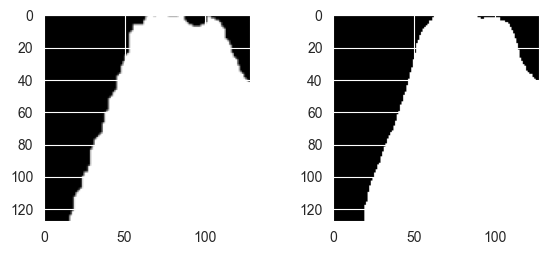

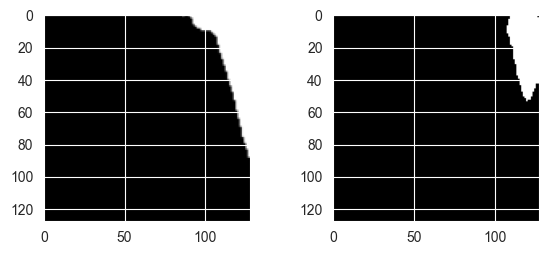

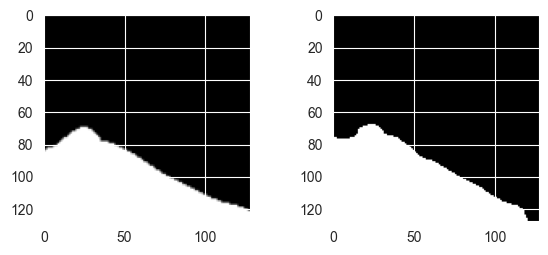

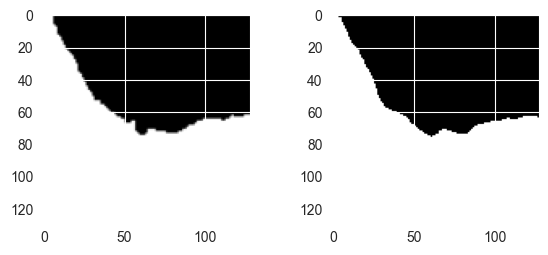

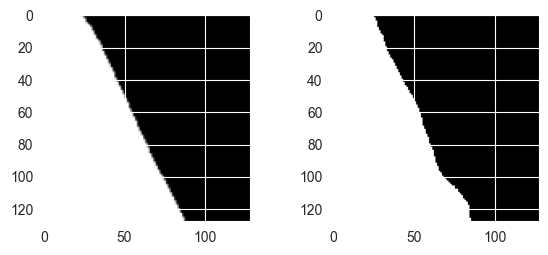

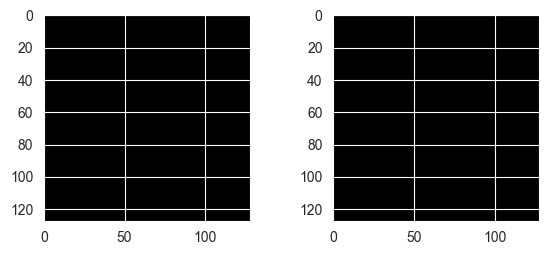

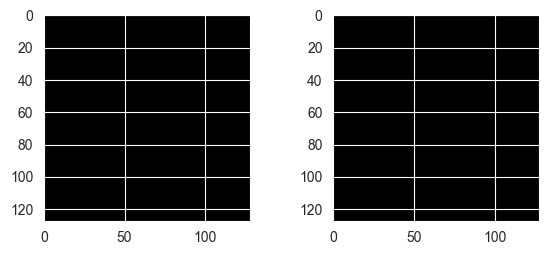

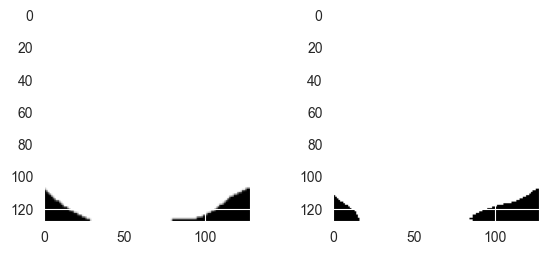

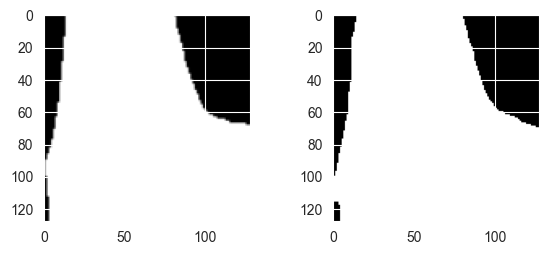

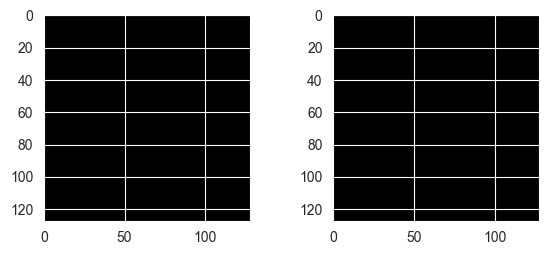

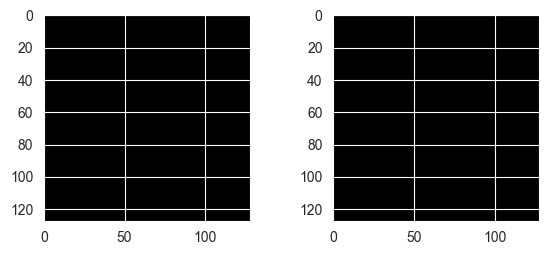

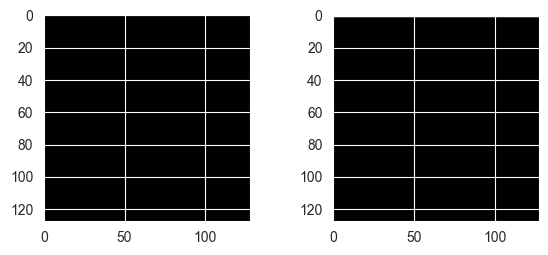

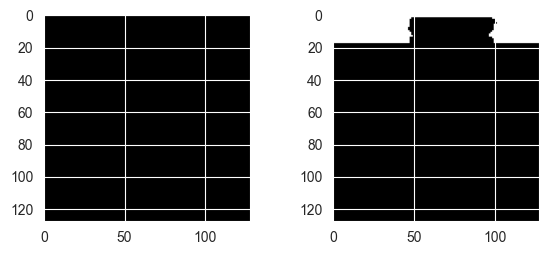

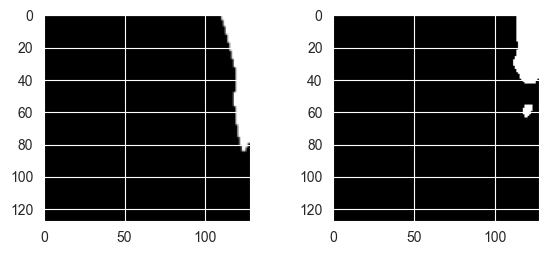

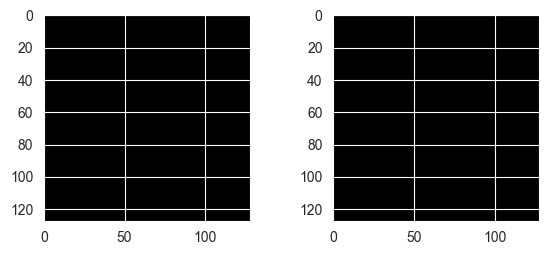

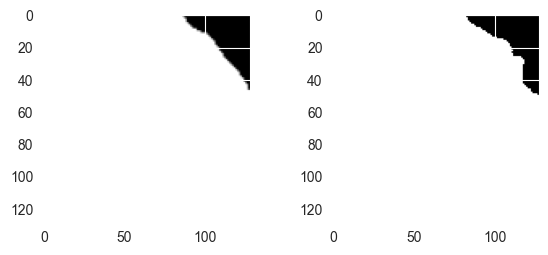

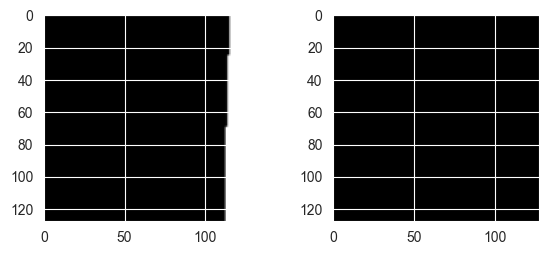

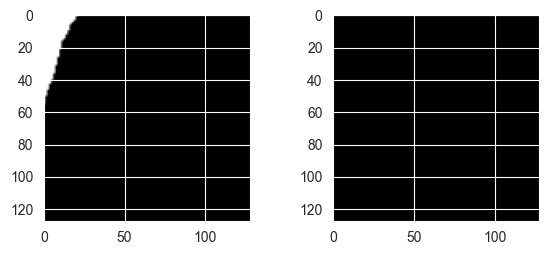

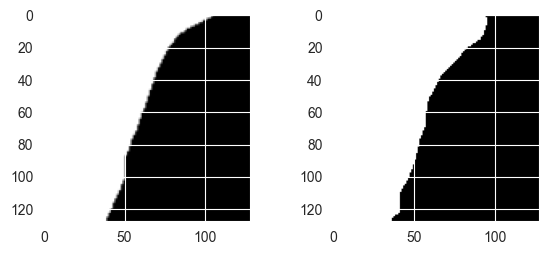

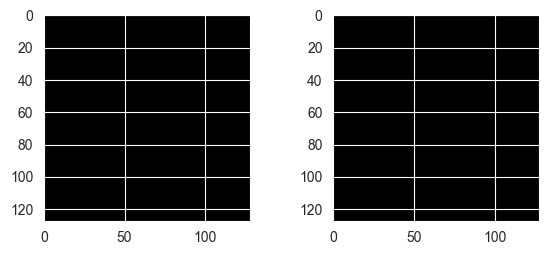

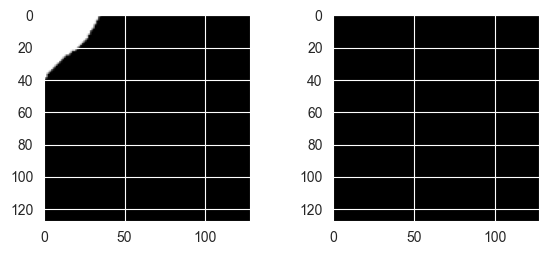

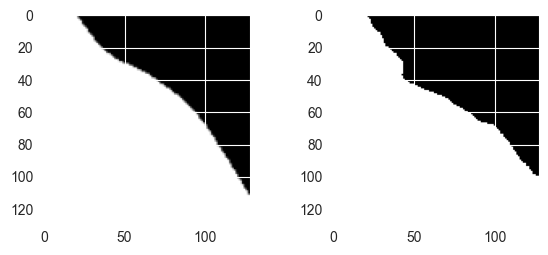

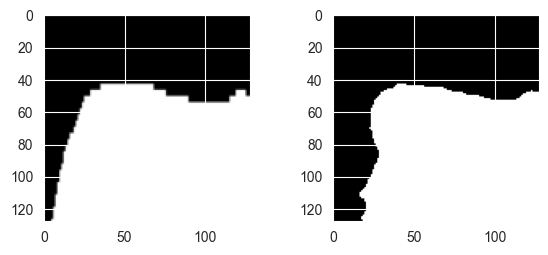

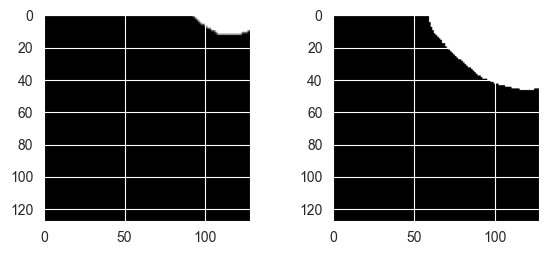

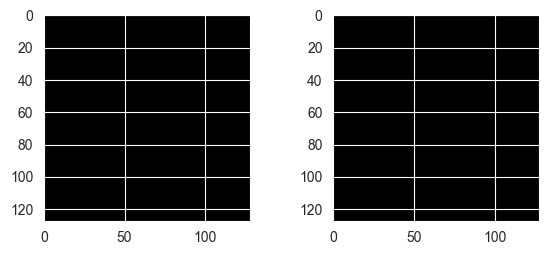

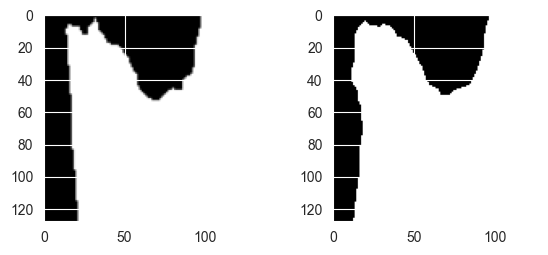

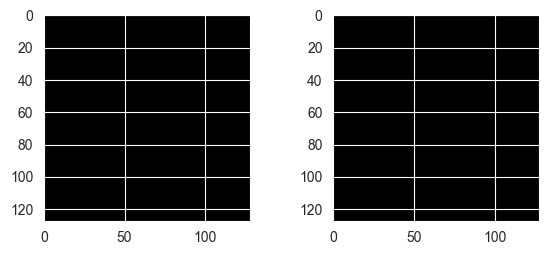

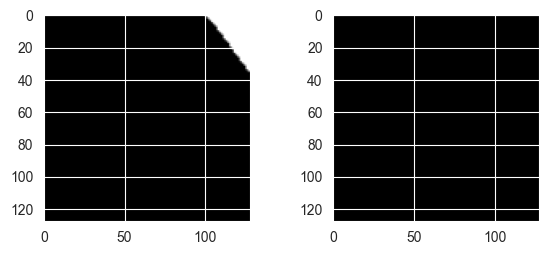

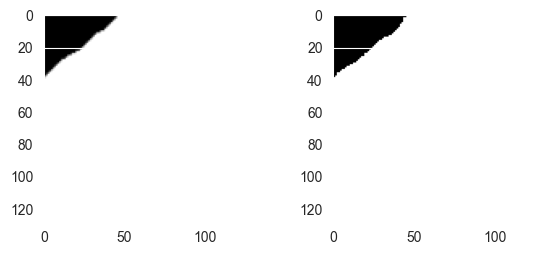

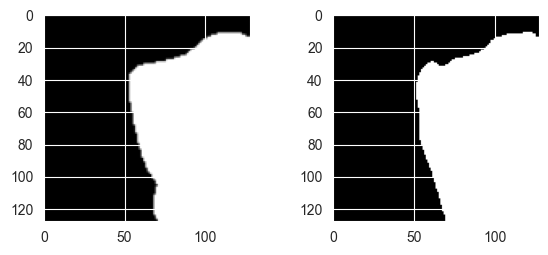

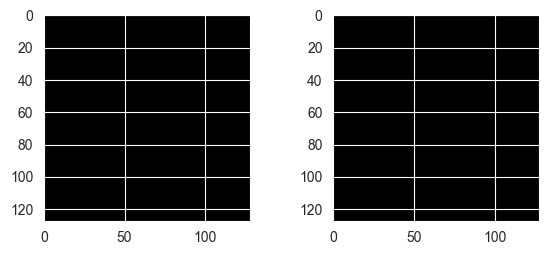

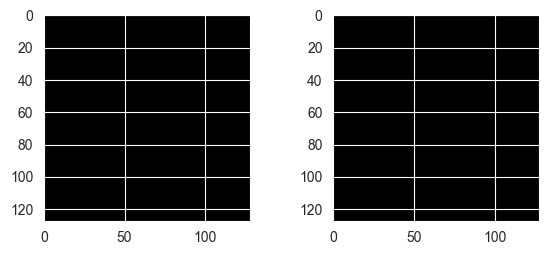

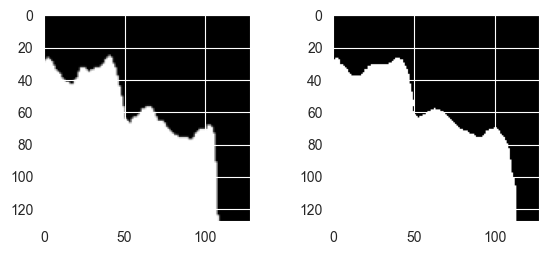

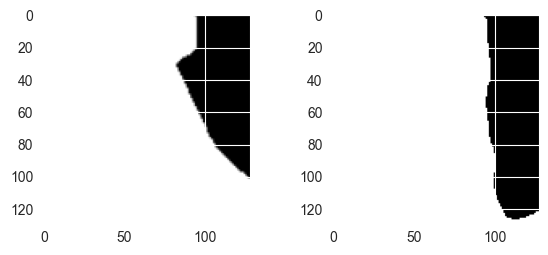

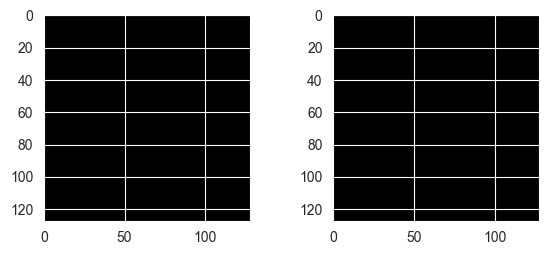

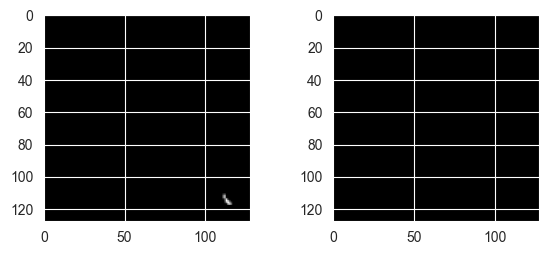

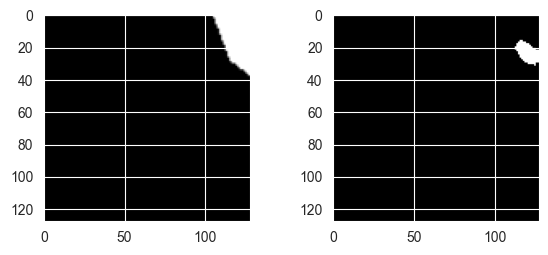

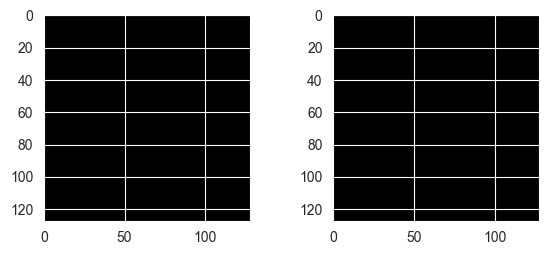

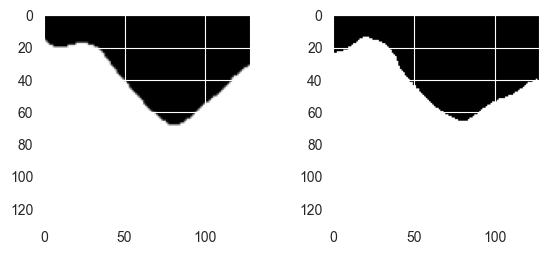

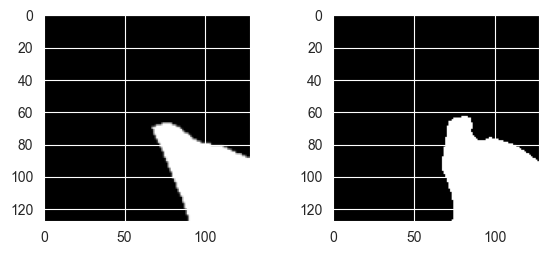

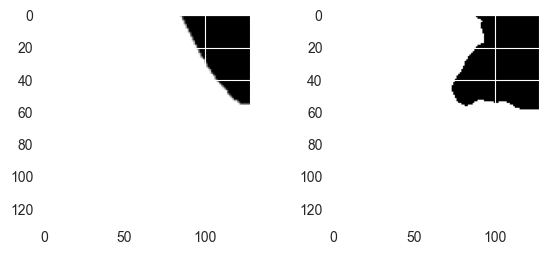

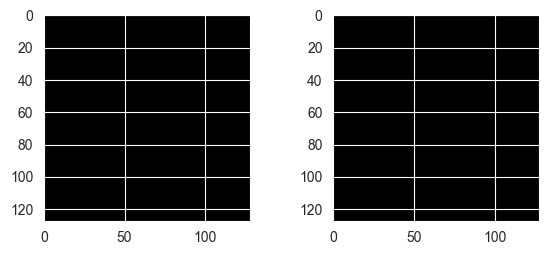

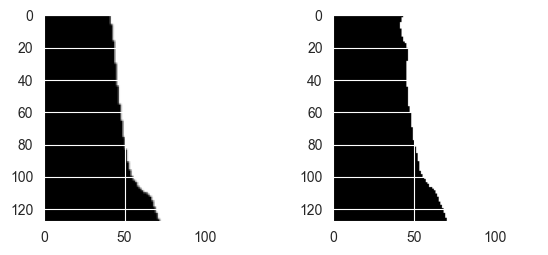

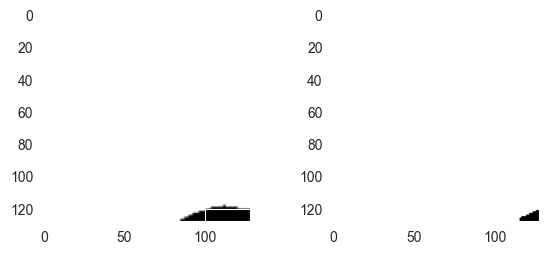

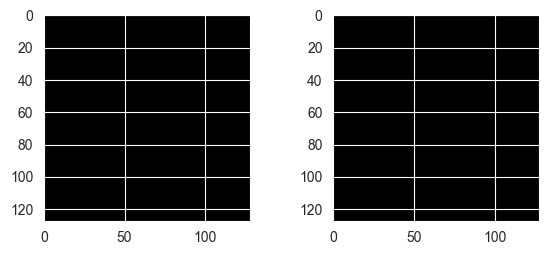

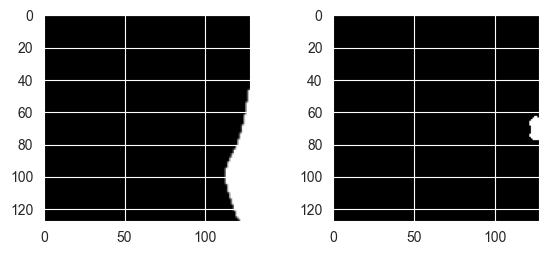

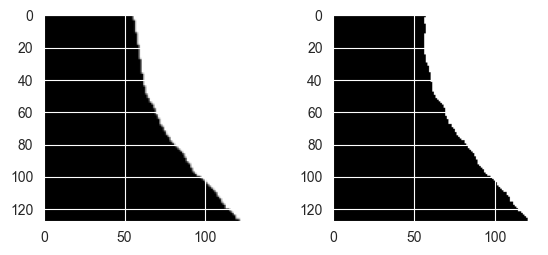

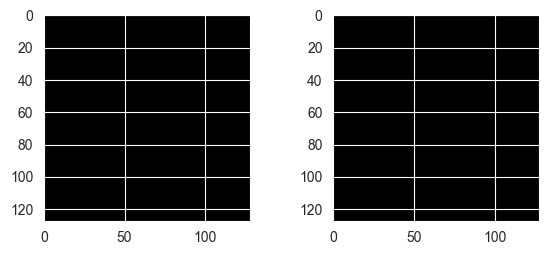

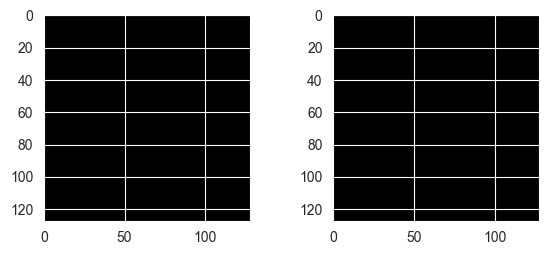

In [77]:
print("\n      Ground Truth            Predicted Value")

for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.4
    
    for i in range(len(result)):
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings

def calculate_metrics(y_true, y_pred):
    y_true = (y_true > 0.5).astype(int)  # Convert to binary array
    y_pred = (y_pred > 0.4).astype(int)  # Convert to binary array

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Suppress warnings
        precision = precision_score(y_true.flatten(), y_pred.flatten(), zero_division='warn')
        recall = recall_score(y_true.flatten(), y_pred.flatten(), zero_division='warn')
        f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division='warn')
        accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    
    return precision, recall, f1, accuracy

performance_metrics = []

for i in range(len(valid_gen)):
    x, y_true = valid_gen.__getitem__(i)
    y_pred = model.predict(x)
    y_pred = (y_pred > 0.4).astype(np.uint8)
    
    for j in range(len(y_true)):
        precision, recall, f1, accuracy = calculate_metrics(y_true[j], y_pred[j])
        performance_metrics.append([precision, recall, f1, accuracy])

# Average performance metrics
average_metrics = np.mean(performance_metrics, axis=0)
print("Average Performance Metrics:")
print("Precision:", average_metrics[0])
print("Recall:", average_metrics[1])
print("F1-score:", average_metrics[2])
print("Accuracy:", average_metrics[3])


1/1 [==============================] - 0s 297ms/step
Average Performance Metrics:
Precision: 0.4380906021389875
Recall: 0.4121900201501418
F1-score: 0.40630073356858754
Accuracy: 0.9352346801757813


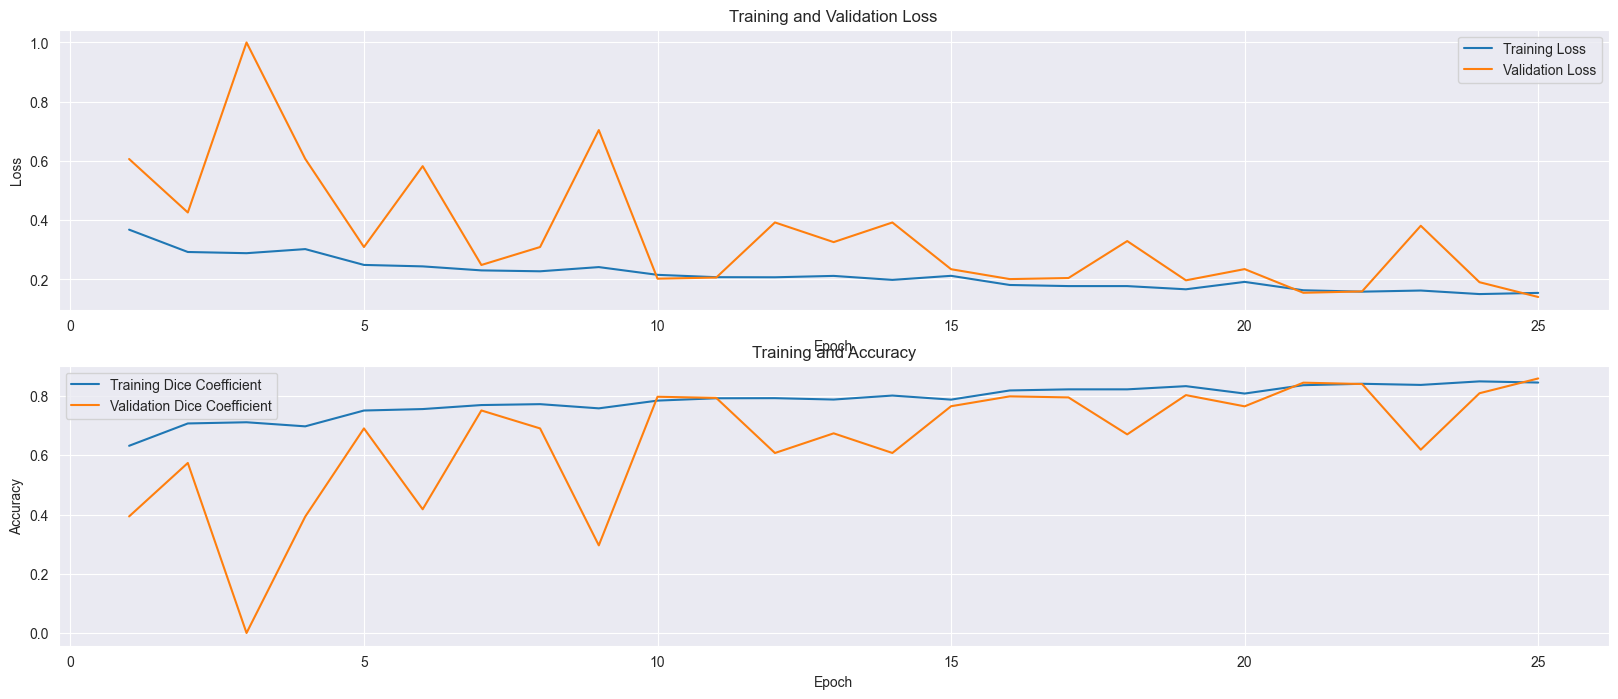

<Figure size 640x480 with 0 Axes>

In [85]:
import matplotlib.pyplot as plt

# Plotting learning curves
plt.figure(figsize=(20, 8))

# Get the number of epochs from the history object
num_epochs = len(history.history['loss'])

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(range(1, num_epochs + 1), history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Training and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Show plot
plt.suptitle('Learning Curve', fontsize=24)
plt.show()
